In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cftime
import calendar
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.path as mpath
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mticker
from matplotlib.colors import TwoSlopeNorm
import imageio
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

In [2]:
ds_ice_59 = xr.open_dataset('/nird/datalake/NS1004K/elihho/slo0059_echam6_BOT_mm_0_1850_var97.nc')
ds_ice_04 = xr.open_dataset('/nird/datalake/NS1004K/elihho/tes0004_echam6_BOT_mm_0_1850_var97.nc')
all_forcing = xr.open_dataset('slo0042+slo0046+slo0050_echam6_BOT_mm_1001_8850_97_NH.nc')
all_forcing = all_forcing.sel(time=slice(70010131.994444, 88501231.994444))

In [3]:
def convert_time(time_array):
    #Converting time to pandas dataframe
    time_df = pd.DataFrame(time_array)#-0.99444445

    #Create empty lists
    time = []
    year = []
    month = []
    date = []
    
    #Split up date format in year, month and day
    for i in range(0,len(time_df[0])):
        time.append(str(time_df[0][i]))
        year.append(int(time[i][0:4])-7001)
        month.append(time[i][4:6])
    
    #Add lists to dataframe
    time_df['year']=year
    time_df['month']=month
    #Get the right format (str, yyyy, mm)
    yyyy=time_df['year'].astype("string").str.zfill(4)
    mm=time_df['month'].astype("string")

    #Combine to datestring in format 'yyyy-mm'
    for i in range(0,len(time_df[0])):
        date_stamp = f'{yyyy[i]}-{mm[i]}'
        date.append(date_stamp)

    #Add date string to dataframe
    time_df['date'] = date
    
    #Convert to datetime object. Works from year 0001!
    def convert_to_datetime(date_str):
        try:
            return datetime.strptime(date_str, '%Y-%m')
        except ValueError as e:
            print(f"Error converting date {date_str}: {e}")
            return pd.NaT
    
    # Apply the conversion function to the 'date' column
    time_df['date'] = time_df['date'].apply(convert_to_datetime)
    return time_df['date']

In [4]:
time_slo = convert_time(ds_ice_59['time'])
time_tes = convert_time(ds_ice_04['time'])
time_all_forcing = convert_time(all_forcing['time'])

Error converting date 0000-01: year 0 is out of range
Error converting date 0000-02: year 0 is out of range
Error converting date 0000-03: year 0 is out of range
Error converting date 0000-04: year 0 is out of range
Error converting date 0000-05: year 0 is out of range
Error converting date 0000-06: year 0 is out of range
Error converting date 0000-07: year 0 is out of range
Error converting date 0000-08: year 0 is out of range
Error converting date 0000-09: year 0 is out of range
Error converting date 0000-10: year 0 is out of range
Error converting date 0000-11: year 0 is out of range
Error converting date 0000-12: year 0 is out of range
Error converting date 0000-01: year 0 is out of range
Error converting date 0000-02: year 0 is out of range
Error converting date 0000-03: year 0 is out of range
Error converting date 0000-04: year 0 is out of range
Error converting date 0000-05: year 0 is out of range
Error converting date 0000-06: year 0 is out of range
Error converting date 0000-0

In [5]:
seaice_tes = ds_ice_04.assign_coords(time = ('time', list(time_tes)))
seaice_slo = ds_ice_59.assign_coords(time = ('time', list(time_slo)))
seaice_all_forcing = all_forcing.assign_coords(time = ('time', list(time_all_forcing)))

In [6]:
seaice_tes_lia = seaice_tes.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))
seaice_slo_lia = seaice_slo.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))
seaice_all_forcing_lia = seaice_all_forcing.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))

In [7]:
# Extract latitude
lat = seaice_tes_lia['lat']

# Calculate weights: cos(lat) in radians
weights = np.cos(np.deg2rad(lat))

artic_lat = slice(89, 60)

artic_lia_tes = seaice_tes_lia['var97'].sel(lat=artic_lat).weighted(weights).mean(dim=['lat', 'lon'])
artic_lia_slo = seaice_slo_lia['var97'].sel(lat=artic_lat).weighted(weights).mean(dim=['lat', 'lon'])
artic_lia_all_forcing = seaice_all_forcing_lia['var97'].sel(lat=artic_lat).weighted(weights).mean(dim=['lat', 'lon'])

In [8]:
def calculate_monthly_mean(array):
    # Assuming 'time' contains datetime.datetime objects
    years = [t.year for t in array['time'].values]
    months = [t.month for t in array['time'].values]
    # Add these as coordinates to your DataArray
    array['year'] = ('time', years)
    array['month'] = ('time', months)

    monthly_mean_data = array.groupby('month').mean(dim='time')
    return monthly_mean_data

In [9]:
monthly_mean_tes = calculate_monthly_mean(artic_lia_tes)
monthly_mean_slo = calculate_monthly_mean(artic_lia_slo)
monthly_mean_all_forcing = calculate_monthly_mean(artic_lia_all_forcing)

In [10]:
artic_1250_1350_tes = artic_lia_tes.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1350, 12, 1, 0, 0)))
artic_1350_1450_tes = artic_lia_tes.sel(time=slice(datetime(1350, 1, 1, 0, 0), datetime(1450, 12, 1, 0, 0)))
artic_1450_1550_tes = artic_lia_tes.sel(time=slice(datetime(1450, 1, 1, 0, 0), datetime(1550, 12, 1, 0, 0)))
artic_1550_1650_tes = artic_lia_tes.sel(time=slice(datetime(1550, 1, 1, 0, 0), datetime(1650, 12, 1, 0, 0)))
artic_1650_1750_tes = artic_lia_tes.sel(time=slice(datetime(1650, 1, 1, 0, 0), datetime(1750, 12, 1, 0, 0)))
artic_1750_1850_tes = artic_lia_tes.sel(time=slice(datetime(1750, 1, 1, 0, 0), datetime(1850, 11, 1, 0, 0)))

artic_1250_1350_slo = artic_lia_slo.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1350, 12, 1, 0, 0)))
artic_1350_1450_slo = artic_lia_slo.sel(time=slice(datetime(1350, 1, 1, 0, 0), datetime(1450, 12, 1, 0, 0)))
artic_1450_1550_slo = artic_lia_slo.sel(time=slice(datetime(1450, 1, 1, 0, 0), datetime(1550, 12, 1, 0, 0)))
artic_1550_1650_slo = artic_lia_slo.sel(time=slice(datetime(1550, 1, 1, 0, 0), datetime(1650, 12, 1, 0, 0)))
artic_1650_1750_slo = artic_lia_slo.sel(time=slice(datetime(1650, 1, 1, 0, 0), datetime(1750, 12, 1, 0, 0)))
artic_1750_1850_slo = artic_lia_slo.sel(time=slice(datetime(1750, 1, 1, 0, 0), datetime(1850, 11, 1, 0, 0)))

artic_1250_1350_all_forcing = artic_lia_all_forcing.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1350, 12, 1, 0, 0)))
artic_1350_1450_all_forcing = artic_lia_all_forcing.sel(time=slice(datetime(1350, 1, 1, 0, 0), datetime(1450, 12, 1, 0, 0)))
artic_1450_1550_all_forcing = artic_lia_all_forcing.sel(time=slice(datetime(1450, 1, 1, 0, 0), datetime(1550, 12, 1, 0, 0)))
artic_1550_1650_all_forcing = artic_lia_all_forcing.sel(time=slice(datetime(1550, 1, 1, 0, 0), datetime(1650, 12, 1, 0, 0)))
artic_1650_1750_all_forcing = artic_lia_all_forcing.sel(time=slice(datetime(1650, 1, 1, 0, 0), datetime(1750, 12, 1, 0, 0)))
artic_1750_1850_all_forcing = artic_lia_all_forcing.sel(time=slice(datetime(1750, 1, 1, 0, 0), datetime(1850, 11, 1, 0, 0)))

In [11]:
monthly_mean_1250_1350_tes = calculate_monthly_mean(artic_1250_1350_tes)
monthly_mean_1350_1450_tes = calculate_monthly_mean(artic_1350_1450_tes)
monthly_mean_1450_1550_tes = calculate_monthly_mean(artic_1450_1550_tes)
monthly_mean_1550_1650_tes = calculate_monthly_mean(artic_1550_1650_tes)
monthly_mean_1650_1750_tes = calculate_monthly_mean(artic_1650_1750_tes)
monthly_mean_1750_1850_tes = calculate_monthly_mean(artic_1750_1850_tes)

monthly_mean_1250_1350_slo = calculate_monthly_mean(artic_1250_1350_slo)
monthly_mean_1350_1450_slo = calculate_monthly_mean(artic_1350_1450_slo)
monthly_mean_1450_1550_slo = calculate_monthly_mean(artic_1450_1550_slo)
monthly_mean_1550_1650_slo = calculate_monthly_mean(artic_1550_1650_slo)
monthly_mean_1650_1750_slo = calculate_monthly_mean(artic_1650_1750_slo)
monthly_mean_1750_1850_slo = calculate_monthly_mean(artic_1750_1850_slo)

monthly_mean_1250_1350_all_forcing = calculate_monthly_mean(artic_1250_1350_all_forcing)
monthly_mean_1350_1450_all_forcing = calculate_monthly_mean(artic_1350_1450_all_forcing)
monthly_mean_1450_1550_all_forcing = calculate_monthly_mean(artic_1450_1550_all_forcing)
monthly_mean_1550_1650_all_forcing = calculate_monthly_mean(artic_1550_1650_all_forcing)
monthly_mean_1650_1750_all_forcing = calculate_monthly_mean(artic_1650_1750_all_forcing)
monthly_mean_1750_1850_all_forcing = calculate_monthly_mean(artic_1750_1850_all_forcing)

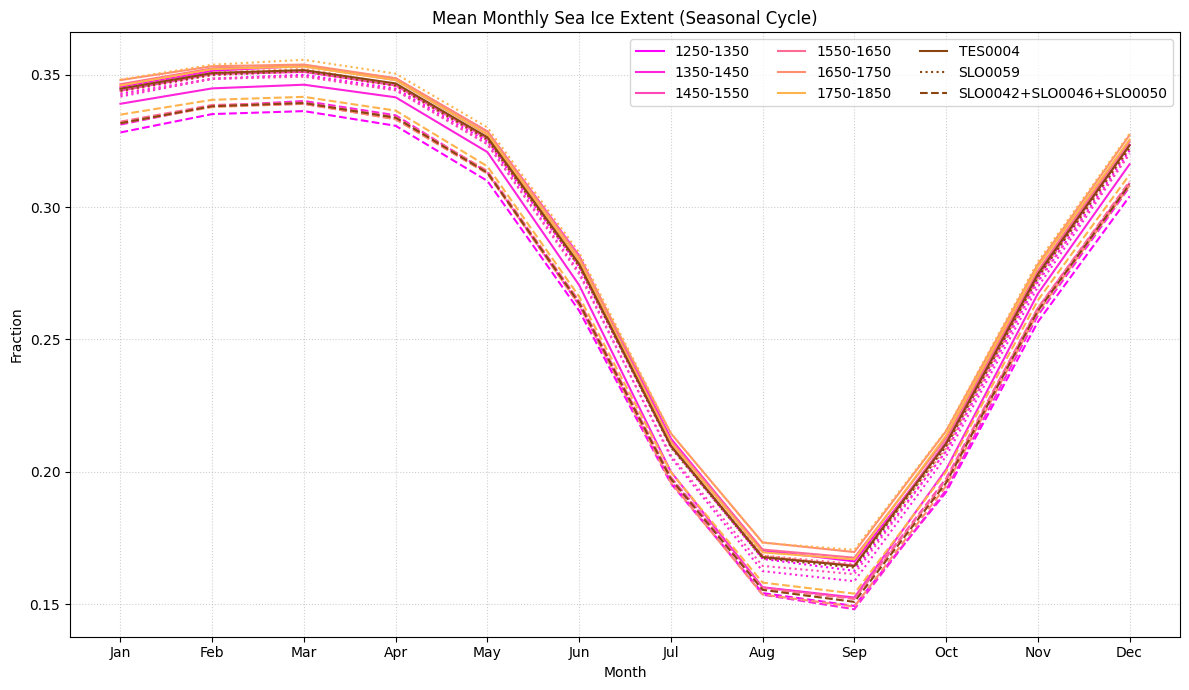

In [12]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Define time periods and assign colors
time_periods = ["1250-1350", "1350-1450", "1450-1550", "1550-1650", "1650-1750", "1750-1850"]
colors = plt.cm.spring(np.linspace(0, 0.7, len(time_periods)))  # 6 distinct colors

# Linestyle mapping
linestyles = {
    "tes": "-",
    "slo": ":",
    "all_forcing": "--"
}

# Collect the data in dictionaries for easy looping
data = {
    "tes": [
        monthly_mean_1250_1350_tes, monthly_mean_1350_1450_tes, monthly_mean_1450_1550_tes,
        monthly_mean_1550_1650_tes, monthly_mean_1650_1750_tes, monthly_mean_1750_1850_tes
    ],
    "slo": [
        monthly_mean_1250_1350_slo, monthly_mean_1350_1450_slo, monthly_mean_1450_1550_slo,
        monthly_mean_1550_1650_slo, monthly_mean_1650_1750_slo, monthly_mean_1750_1850_slo
    ],
    "all_forcing": [
        monthly_mean_1250_1350_all_forcing, monthly_mean_1350_1450_all_forcing, monthly_mean_1450_1550_all_forcing,
        monthly_mean_1550_1650_all_forcing, monthly_mean_1650_1750_all_forcing, monthly_mean_1750_1850_all_forcing
    ]
}

plt.figure(figsize=(12, 7))

# Loop over models and periods
for model, model_data in data.items():
    for i, da in enumerate(model_data):
        plt.plot(
            months, da.values,  # force months on x-axis
            label=f"{time_periods[i]}" if model == "tes" else None,  # only label once per time period
            color=colors[i],
            linestyle=linestyles[model]
        )

# Reference lines
plt.plot(months, monthly_mean_tes.values, linestyle='-',  color='saddlebrown', label='TES0004')
plt.plot(months, monthly_mean_slo.values, linestyle=':', color='saddlebrown', label='SLO0059')
plt.plot(months, monthly_mean_all_forcing.values, linestyle='--', color='saddlebrown', label='SLO0042+SLO0046+SLO0050')

plt.title("Mean Monthly Sea Ice Extent (Seasonal Cycle)")
plt.ylabel("Fraction")
plt.xlabel("Month")
plt.legend(ncol=3)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


In [13]:
rolling_year = 5
rolling_months = rolling_year*12

In [14]:
artic_lia_smoothed_tes = artic_lia_tes.rolling(time=rolling_months, center=True).mean()
artic_lia_smoothed_slo = artic_lia_slo.rolling(time=rolling_months, center=True).mean()
artic_lia_smoothed_all_forcing = artic_lia_all_forcing.rolling(time=rolling_months, center=True).mean()

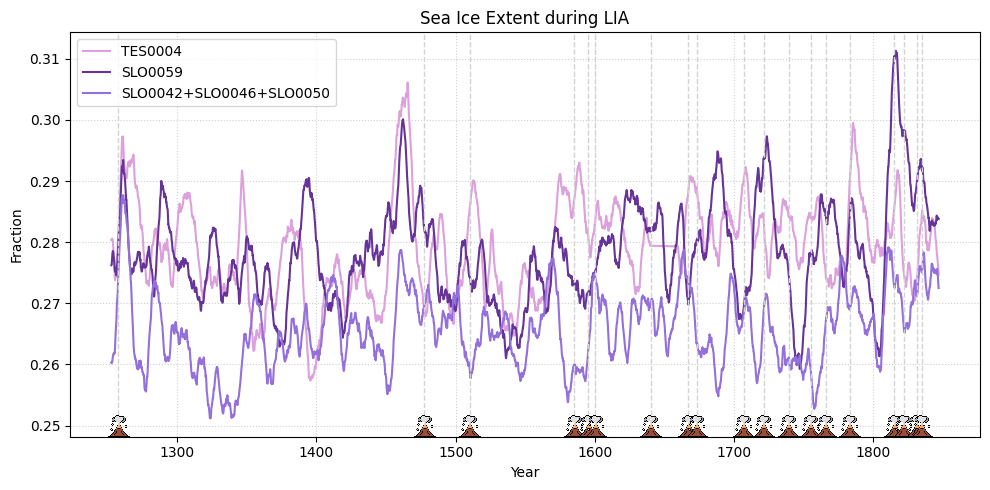

In [15]:
volcano_years = [1257, 1477, 1510, 1585, 1595, 1600, 1640, 1667, 1673, 1707,
                 1721, 1739, 1755, 1766, 1783, 1815, 1822, 1831, 1835]

volcano = [datetime(year, 7, 1) for year in volcano_years]

volcano_img = mpimg.imread("volcano.png")
volcano_icon = OffsetImage(volcano_img, zoom=0.03)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(artic_lia_tes['time'], artic_lia_smoothed_tes, linestyle='-', color='plum', label='TES0004')
ax.plot(artic_lia_slo['time'], artic_lia_smoothed_slo.values, linestyle='-', color='rebeccapurple', label='SLO0059')
ax.plot(artic_lia_all_forcing['time'], artic_lia_smoothed_all_forcing.values, linestyle='-', color='mediumpurple', label='SLO0042+SLO0046+SLO0050')

for vt in volcano:
    ax.axvline(x=vt, color='lightgray', linestyle='--', linewidth=1)
    ab = AnnotationBbox(volcano_icon, (vt, ax.get_ylim()[0]), frameon=False, box_alignment=(0.5, 0))
    ax.add_artist(ab)

ax.set_title("Sea Ice Extent during LIA")
ax.set_ylabel("Fraction")
ax.set_xlabel("Year")
ax.legend()
ax.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

### Maps of extention after eruptions

In [16]:
artic_lia_tes

<xarray.DataArray 'var97' (time: 6959)> Size: 56kB
array([0.34390341, 0.35118029, 0.35159298, ..., 0.14818708, 0.19142139,
       0.26607788])
Coordinates:
  * time     (time) object 56kB 1250-01-01 1250-02-01 ... 1849-10-01 1849-11-01
    year     (time) int64 56kB 1250 1250 1250 1250 1250 ... 1849 1849 1849 1849
    month    (time) int64 56kB 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11

In [17]:
def march_per_year_from_datetime(ds):
  
    march = ds.sel(time=ds.month == 3)
    return march

march_tes = march_per_year_from_datetime(artic_lia_tes)
march_slo = march_per_year_from_datetime(artic_lia_slo)
march_all_forcing = march_per_year_from_datetime(artic_lia_all_forcing)

In [18]:
def sea_ice_sea(data, eruption_years, window_before=5, window_after=15):
    window_length = window_before + window_after + 1
    all_anomalies = []

    for eruption_year in eruption_years:
        start_year = eruption_year - window_before
        end_year = eruption_year + window_after
        
        # Check if all years in window exist in data
        years_window = np.arange(start_year, end_year + 1)
        if not np.all(np.isin(years_window, data.year.values)):
            print(f"Skipping year {eruption_year}: incomplete window")
            continue
        
        # Select the window slice
        window_slice = data.sel(year=slice(start_year, end_year))
        if window_slice.size != window_length:
            print(f"Skipping year {eruption_year}: window size mismatch")
            continue
        
        # Calculate baseline mean from years before eruption (exclude eruption year)
        baseline_slice = data.sel(year=slice(start_year, eruption_year - 1))
        baseline_mean = baseline_slice.mean().item()
        
        # Compute anomaly relative to baseline mean
        anomaly = window_slice - baseline_mean
        
        # Assign coordinate for lag: years relative to eruption_year
        lags = np.arange(-window_before, window_after + 1)
        anomaly = anomaly.assign_coords(year=lags)
        anomaly = anomaly.rename({'year': 'lag'})
        
        all_anomalies.append(anomaly)
    
    if len(all_anomalies) == 0:
        raise ValueError("No valid eruption events with complete windows found.")
    
    # Stack anomalies along new 'event' dimension
    stacked = xr.concat(all_anomalies, dim='event')
    
    # Calculate mean and std across events
    mean_anomaly = stacked.mean(dim='event')
    std_anomaly = stacked.std(dim='event')
    
    return mean_anomaly.lag.values, mean_anomaly, std_anomaly

In [19]:
eruption_years = [1257, 1477, 1510, 1585, 1595, 1640, 1667, 1673, 1707,
                  1721, 1739, 1755, 1766, 1783, 1815, 1822, 1831]

march_data_tes = march_tes.swap_dims({'time': 'year'}).drop_vars('time')
march_data_slo = march_slo.swap_dims({'time': 'year'}).drop_vars('time')
march_data_all_forcing = march_all_forcing.swap_dims({'time': 'year'}).drop_vars('time')

Skipping year 1640: incomplete window


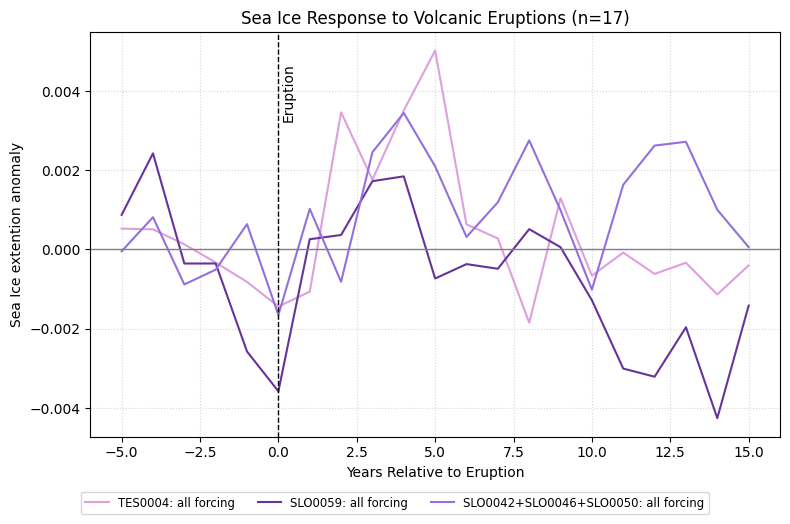

In [20]:
lags_tes, mean_anomaly_tes, std_anomaly_tes = sea_ice_sea(march_data_tes, eruption_years)
lags_slo, mean_anomaly_slo, std_anomaly_slo = sea_ice_sea(march_data_slo, eruption_years)
lags_all_forcing, mean_anomaly_all_forcing, std_anomaly_all_forcing = sea_ice_sea(march_data_all_forcing, eruption_years)


fig, ax = plt.subplots(figsize=(8, 5))

# Smoothed lines
ax.plot(lags_tes, mean_anomaly_tes, color='plum', label='TES0004: all forcing')
ax.plot(lags_slo, mean_anomaly_slo, color='rebeccapurple', label='SLO0059: all forcing')
ax.plot(lags_all_forcing, mean_anomaly_all_forcing, color='mediumpurple', label='SLO0042+SLO0046+SLO0050: all forcing')

ax.axhline(0, color='gray', linestyle='-', lw=1)
ax.axvline(0, color='black', linestyle='--', lw=1) 
ax.text(0.1, ax.get_ylim()[1]*0.6, 'Eruption', rotation=90, color='black')

ax.set_ylabel('Sea Ice extention anomaly')
ax.set_xlabel('Years Relative to Eruption')
ax.set_title(f'Sea Ice Response to Volcanic Eruptions (n={len(eruption_years)})')

ax.grid(True, linestyle=':', alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()

In [21]:
def rolling_mean(data, window):
    return np.convolve(data, np.ones(window)/window, mode='same')

In [22]:
mean_response_tes_smoothed = rolling_mean(mean_anomaly_tes, window=3)
mean_response_slo_smoothed = rolling_mean(mean_anomaly_slo, window=3)
mean_response_all_forcing_smoothed = rolling_mean(mean_anomaly_all_forcing, window=3)

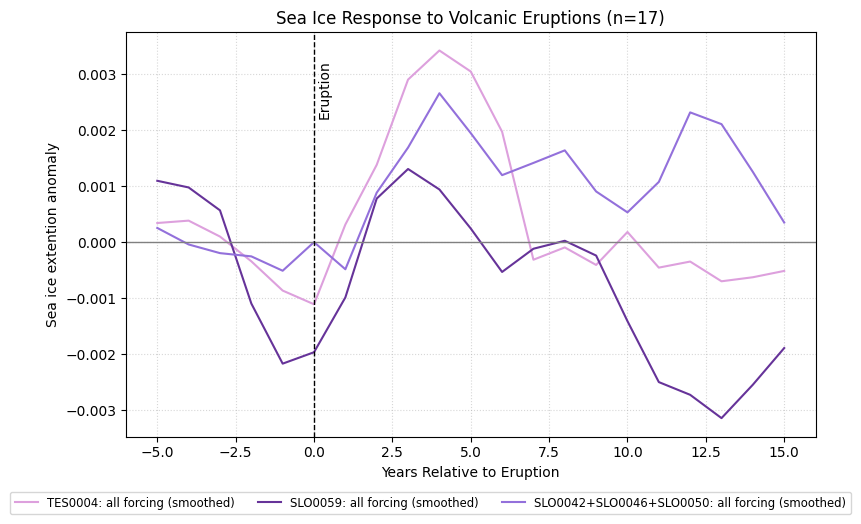

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))

# Smoothed lines
ax.plot(lags_tes, mean_response_tes_smoothed, color='plum', label='TES0004: all forcing (smoothed)')
ax.plot(lags_slo, mean_response_slo_smoothed, color='rebeccapurple', label='SLO0059: all forcing (smoothed)')
ax.plot(lags_all_forcing, mean_response_all_forcing_smoothed, color='mediumpurple', label='SLO0042+SLO0046+SLO0050: all forcing (smoothed)')

ax.axhline(0, color='gray', linestyle='-', lw=1)
ax.axvline(0, color='black', linestyle='--', lw=1) 
ax.text(0.1, ax.get_ylim()[1]*0.6, 'Eruption', rotation=90, color='black')

ax.set_ylabel('Sea ice extention anomaly')
ax.set_xlabel('Years Relative to Eruption')
ax.set_title(f'Sea Ice Response to Volcanic Eruptions (n={len(eruption_years)})')

ax.grid(True, linestyle=':', alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()

In [36]:
def sea_maps(data, eruption_years, window_before=5, window_after=10):
    lags = np.arange(-window_before, window_after + 1)
    anomalies = []

    for year in eruption_years:
        start = year - window_before
        end = year + window_after

        if (start in data.year.values) and (end in data.year.values):
            event = data.sel(year=slice(start, end))

            if event.sizes["year"] == len(lags):
                # pre-eruption baseline
                pre_event_mean = event.sel(year=slice(year - window_before, year - 1)).mean("year")

                # anomalies
                anomaly = event - pre_event_mean

                # rename 'year' -> 'lag'
                anomaly = anomaly.rename({"year": "lag"})
                anomaly = anomaly.assign_coords(lag=lags)

                anomalies.append(anomaly)

    if not anomalies:
        raise ValueError("No valid eruption windows found.")

    stacked = xr.concat(anomalies, dim="event")
    mean_map = stacked.mean("event")
    std_map = stacked.std("event")

    return lags, mean_map, std_map, stacked

In [37]:
def calculate_month(array):
    # Assuming 'time' contains datetime.datetime objects
    years = [t.year for t in array['time'].values]
    months = [t.month for t in array['time'].values]
    # Add these as coordinates to your DataArray
    array['year'] = ('time', years)
    array['month'] = ('time', months)

    monthly_data = array.groupby('month')
    return monthly_data

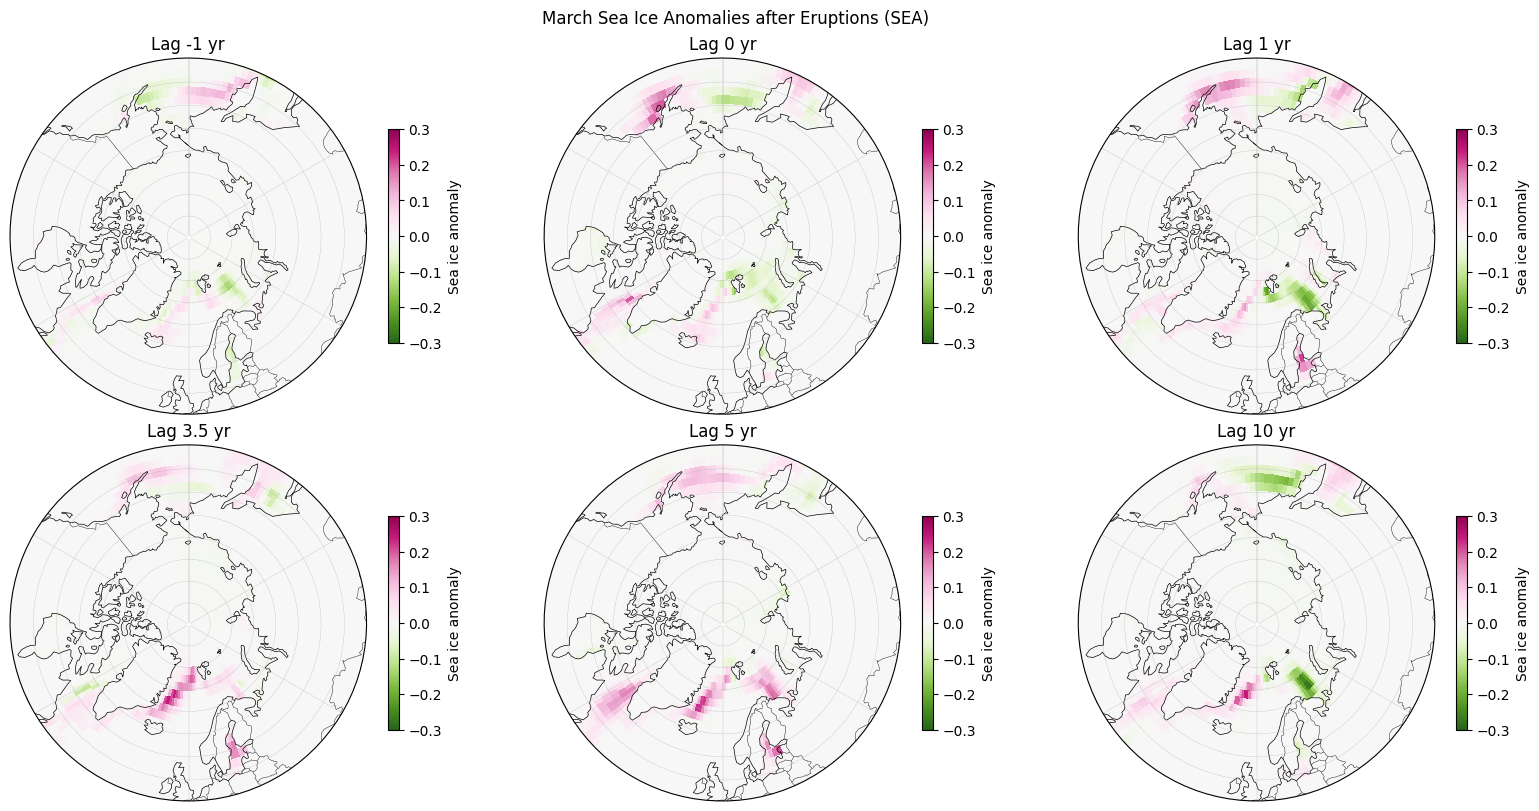

In [48]:
# pick March first
seaice_tes  = seaice_tes_lia['var97']
monthly = calculate_month(seaice_tes)
march_tes = monthly[3]
march_data_tes = march_tes.swap_dims({'time': 'year'}).drop_vars('time')
# run SEA
lags, mean_map, std_map, mapmap = sea_maps(march_data_tes, eruption_years)

# Helper function to set latitudinal limits
# from https://nordicesmhub.github.io/NEGI-Abisko-2019/training/example_NorthPolarStereo_projection.html
def polarCentral_set_latlim(lat_lims, ax):
    # Set extent in geographic coordinates
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], crs=ccrs.PlateCarree())

    # Make circular boundary (center of axes)
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

lags_to_plot = [-1, 0, 1, 3.5, 5, 10]

fig, axes = plt.subplots(2,3,
                         figsize=(16, 8),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()},
                         constrained_layout=True)

# Flatten axes array
axes = axes.flatten()


for ax, lag in zip(axes, lags_to_plot):
    polarCentral_set_latlim((50, 90), ax)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.gridlines(draw_labels=False, linewidth=0.2)

    # Plot the mean anomaly
    mean_map.sel(lag=lag, method='nearest').plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="PiYG_r",
        center=0,
        vmin=-0.3, vmax=0.3,
        cbar_kwargs={"shrink": 0.6, "label": "Sea ice anomaly"}
    )

    ax.set_title(f"Lag {lag} yr")

plt.suptitle("March Sea Ice Anomalies after Eruptions (SEA)")
plt.show()

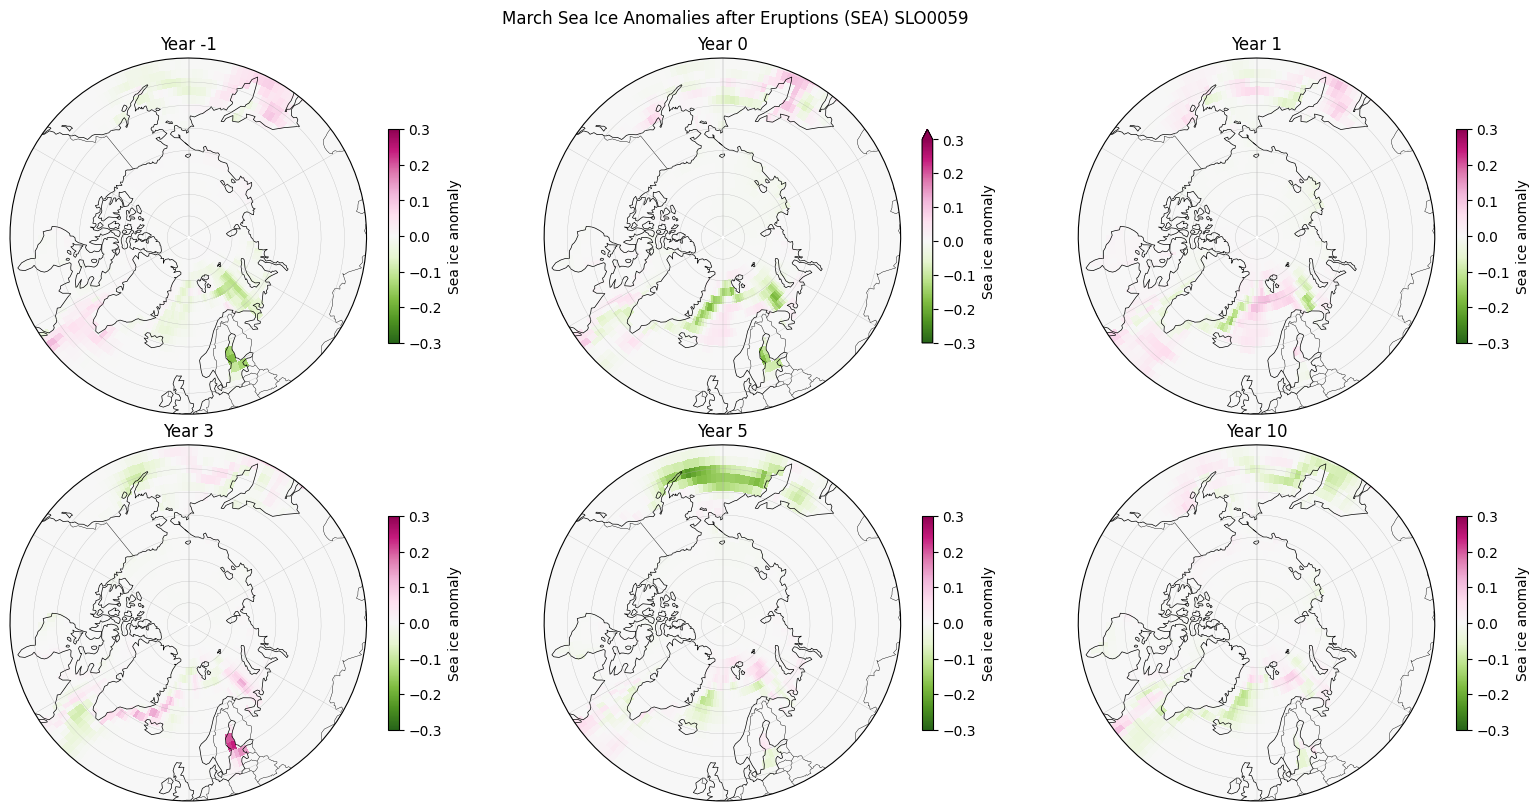

In [46]:
# pick March first
seaice_tes  = seaice_slo_lia['var97']
monthly = calculate_month(seaice_tes)
march_slo = monthly[3]
march_data_slo = march_slo.swap_dims({'time': 'year'}).drop_vars('time')
# run SEA
lags, mean_map, std_map, mapmap = sea_maps(march_data_slo, eruption_years)

# Helper function to set latitudinal limits
# from https://nordicesmhub.github.io/NEGI-Abisko-2019/training/example_NorthPolarStereo_projection.html
def polarCentral_set_latlim(lat_lims, ax):
    # Set extent in geographic coordinates
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], crs=ccrs.PlateCarree())

    # Make circular boundary (center of axes)
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

lags_to_plot = [-1, 0, 1, 3, 5, 10]

fig, axes = plt.subplots(2,3,
                         figsize=(16, 8),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()},
                         constrained_layout=True)

# Flatten axes array
axes = axes.flatten()

for ax, lag in zip(axes, lags_to_plot):
    polarCentral_set_latlim((50, 90), ax)
    ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.gridlines(draw_labels=False, linewidth=0.2)

    # plot anomaly
    mean_map.sel(lag=lag, method='nearest').plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="PiYG_r",
        vmin=-0.3, vmax=0.3,
        center=0,
        cbar_kwargs={"shrink": 0.6, "label": "Sea ice anomaly"}
    )
    ax.set_title(f"Year {lag}")

plt.suptitle("March Sea Ice Anomalies after Eruptions (SEA) SLO0059")
plt.show()

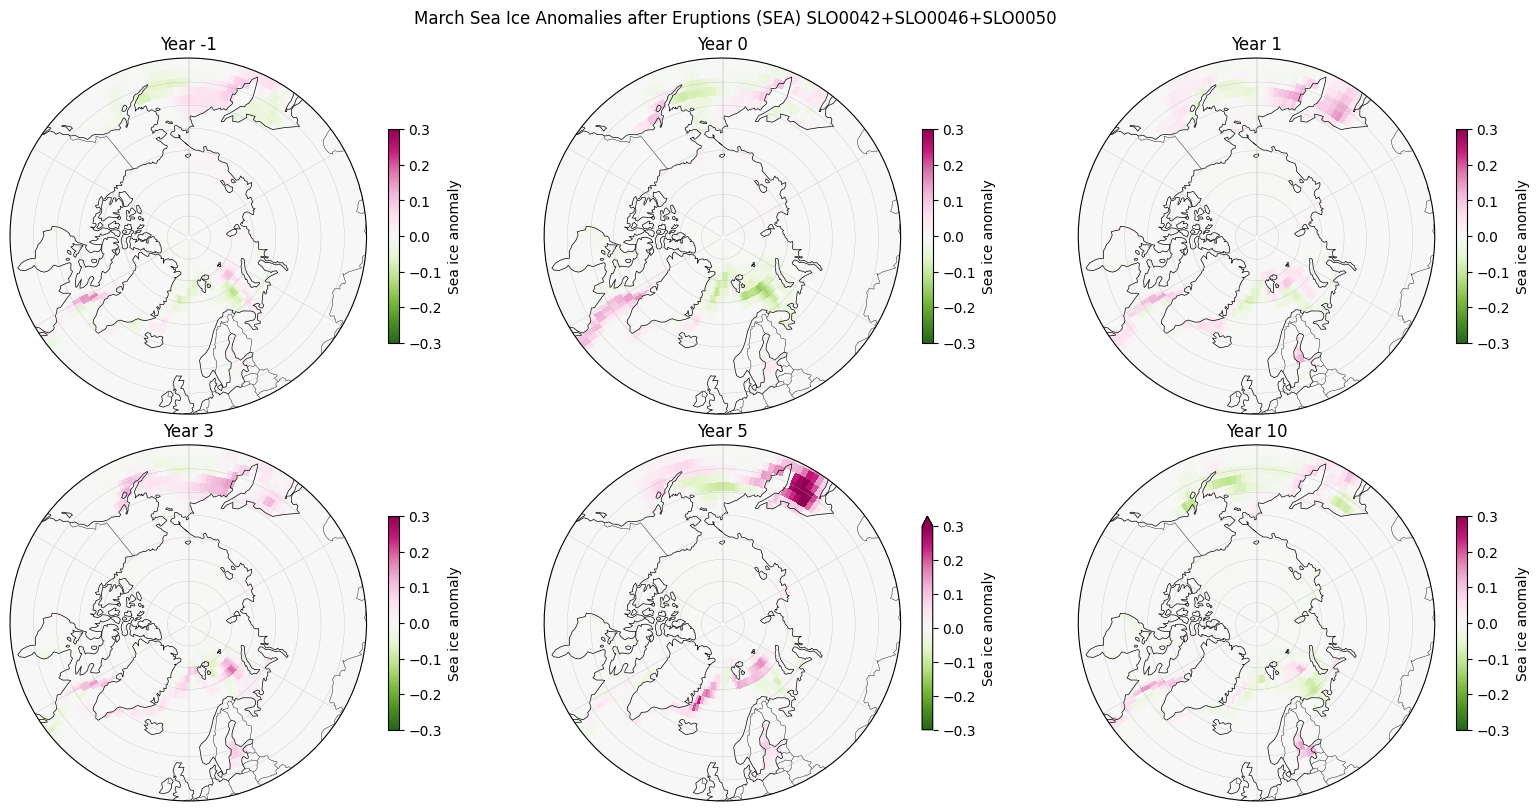

In [47]:
# pick March first
seaice_all_forcing  = seaice_all_forcing_lia['var97']
monthly = calculate_month(seaice_all_forcing)
march_all_forcing = monthly[3]
march_data_all_forcing = march_all_forcing.swap_dims({'time': 'year'}).drop_vars('time')
# run SEA
lags, mean_map, std_map, mapmap = sea_maps(march_data_all_forcing, eruption_years)

# Helper function to set latitudinal limits
# from https://nordicesmhub.github.io/NEGI-Abisko-2019/training/example_NorthPolarStereo_projection.html
def polarCentral_set_latlim(lat_lims, ax):
    # Set extent in geographic coordinates
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], crs=ccrs.PlateCarree())

    # Make circular boundary (center of axes)
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

lags_to_plot = [-1, 0, 1, 3, 5, 10]

fig, axes = plt.subplots(2,3,
                         figsize=(16, 8),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()},
                         constrained_layout=True)

# Flatten axes array
axes = axes.flatten()

for ax, lag in zip(axes, lags_to_plot):
    polarCentral_set_latlim((50, 90), ax)
    ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.gridlines(draw_labels=False, linewidth=0.2)

    # plot anomaly
    mean_map.sel(lag=lag, method='nearest').plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="PiYG_r",
        vmin=-0.3, vmax=0.3,
        center=0,
        cbar_kwargs={"shrink": 0.6, "label": "Sea ice anomaly"}
    )
    ax.set_title(f"Year {lag}")

plt.suptitle("March Sea Ice Anomalies after Eruptions (SEA) SLO0042+SLO0046+SLO0050")
plt.show()